$$\bf{\text{XGBoost}}$$

#### What is XGBoost?

> XGBoost, also known as Extreme gradient boosting, is an implementation of gradient boosting that’s designed for computational speed and scale. XGBoost leverages multiple cores on the CPU, allowing for learning to occur in parallel during training. - *IBM*

> XGBoost and Gradient Boosting Machines (GBMs) are both ensemble tree methods that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. However, XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements. - *Towards Data Science*

> XGBoost is an open-source software library which provides a regularizing gradient boosting framework for C++, Java, Python, R Julia, Perl, and Scala. It works on Linux, Windows, and macOS. From the project description, it aims to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library". It runs on a single machine, as well as the distributed processing frameworks Apache Hadoop, Apache Spark, Apache Flink, and Dask. - *Wikipedia*

Like Gradient Boosting, XGboost, which is also known as extreme gradient boosting, applies the principles of boosting weak learners using the gradient descent algorithm. However, it is particularly designed for computational speed and scale. This means that it can run on distributed processing framework to allow for paralle training.

XGBoost以Gradient Boosting的框架为基础被用于提升计算速度和计算规模。该算法可以在单个计算机上运行，使用计算机的多个内核允许模型在训练时平行式学习。同时，XGBoost也可以被用于分布式计算框架，例如Apache Hadoop、Apache Spark等，可以大幅度提升计算速度和规模。


#### Features of XGBoost

- Gradient Boosting. XGBoost使用Gradient Boosting作为框架进行模型训练。换言之，XGBoost也是采用gradient descent算法来寻找最优的$\gamma$（节点预测值）以最小化损失函数。
- Stochastic Gradient Boosting. XGBoost每次训练新的决策树时，会对训练样本随机抽取训练子集（subsample<1.0）作为新模型的训练集，
- Regularized Gradient Boosting XGBoost. 与Gradient Boosting不同，XGBoost会在目标函数中引入正态项，L1和L2惩罚项，来防止过度拟合问题。
- Parallization. 如果XGBoost在单台机器上运行，XGBoost可以调用计算机CPU的所有cores进行模型训练，实现平行式训练，大幅提升了模型训练效率。这个与Gradient Boosting形成鲜明对比，其只能按照顺序训练模型，即sequential training。
- Distributed Processing. XGBoost同时可以被运用于分布式计算框架，即可以用a cluster of machines训练模型。
- 有效处理空值


#### How XGBoost Works?

这里以XGBoost Regressor为例。

***Note: 本人数学并不具备足够的基础应付目标函数求最优解时的推导过程，所以直接给出最优解的形式。这里的重心在于XGBoost的运行逻辑是什么，以及一些关键的参数会对模型产生什么影响。***

**Step 0: Define Loss Function**

首先，常用的Loss Function可以被定义为：

$$L(y_i,\hat{y}_i) = \frac{1}{2n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$$

因为XGBoost使用Gradient Boosting为框架，以决策树作为weak learners训练模型。也就是说每次迭代的时候都会将旧模型的误差作为新模型的response variable，进行预测。所以我们需要定义出Gradient Boosting的损失函数:

我们知道，Gradient Boosting最开始会初始化预测值，直接取y的平均作为最初预测：

$$\hat{y} = \bar{y}$$

然后开始进行boosting来学习每个模型的errors：

$$\hat{y}^{(1)} = \hat{y} + O_{value}, \text{iteration 1}\\
\hat{y}^{(2)} = \hat{y}^{(1)} + O^{(1)}_{value} , \text{iteration 2}\\
\dots\\
\hat{y}^{(T)} = \hat{y}^{(t-1)} + O^{(t)}_{value} , \text{iteration T}\\
$$

所以我们可以写出Gradient Boosting的Loss Function:

$$\frac{1}{2n}\min{\sum_{i=1}^n{(y_i - \hat{y}_i - O_{value})^2}}$$

现在，XGBoost在Gradient Boosting的基础上，引入了正则项目，所以最终可以得出XGBoost的目标函数：

$$
\min{\sum_{i=1}^nL(y_i,\hat{y}_i+O_{value})} + \frac{1}{2}\lambda O^2_{value}=\\ 
\min{[\sum_{i=1}^n{(y_i - \hat{y}_i - O_{value})^2}] + \frac{1}{2} \lambda O^2_{value}}
$$

- $\lambda$ 是*Learning Rate*控制每一颗树的贡献度
- $O_{value}$ 是决策树每个节点的预测值

所以我们的任务转变成找出最佳的output value使得这个目标函数达到最小值。因为我数学基础不够支撑这里的推导过程，所以我就直接写出经过泰勒展开后求导得出的最优解：

$$O_{value} = \frac{\text{Sum of Residuals}}{\text{Number of Residuals}+\lambda}$$

**Step 1: Make Initial Prediction and Calculate Similarity Score**

定义好目标函数后，初始化预测值，然后计算节点的*Similarity Score*. 公式如下：

$$\text{Similarity Score} = \frac{\text{Sum of Residuals, Squared}}{\text{Number of Residuals} + \lambda}$$

初始化的预测值通常为目标变量的均值，当然我们可以预测任意其他值。

**How to understand the Similarity Score?**

Higher similarity score more homogeneity of residuals in a mode. 

**Step 2: Calulate Similarity Gain**

然后选用特征划分决策树。具体选用哪一个特征需要对比Similarity Gain。

创建新节点后，我们可以计算出划分后节点的similarity score，然后将新的similarity score与划分前根节点的similarity score相减可以得出*information gain*.

$$\text{Gain} = \text{New Similarity Score - Old Similarity Score}$$

- $Gain > 0$ 说明该划分提升了节点中残差的相似度，那么该splitting就是有益的。
- $Gain < 0$ 说明该划分没有提升节点中残差的相似度，反而降低了相似度，则我们不应该允许这次划分。

**Step 3: Create a tree with desired length by Pruning and Regularization**

我们运用上述计算information gain的方法同时实施*剪枝*和*正则化*帮助模型训练出一个理想深度的决策树。这里的剪枝和正则化通过$\gamma$和$\lambda$实现。

$\bf{\color{crimson}{\text{如何判断是否应该剪枝？}}}$

第二步提到**“Similarity Gain可以判断节点划分是否有利于节点内残差相似度的提升”**，但是如果树的节点越多，意味着划分的次数越多，则树模型越容易过度拟合残差值。所以XGBoost才会引入正则项来压制树木的随意生长。XGBoost引入一个额外的参数$\gamma$，然后与每次的splitting后计算出的Similarity Gain对比：

- $\text{Similarity Gain} > \gamma$ 这时信息增益超过了我们预先设定的阀值，所以XGBoost允许该划分
- $\text{Similarity Gain} < \gamma$ 这时信息增益低于我们预先设定的阀值，所以XGBoost会直接剪枝

$\bf{\color{crimson}{\gamma \text{与} \lambda \text{怎么理解？}}}$

$\gamma$

如果我们的Similarity Score为110:

- $\gamma$越大，例如为130，此时超过了110，此时发生剪枝。所以$\gamma$越大，越容易发生剪枝，模型出现overfitting的可能性越小。
- $\gamma$越小，例如为0，此时增益大于设定的阀值，XGBoost会允许这次splitting。则模型对残差拟合效果越好，出现overfitting的可能性越大。

$\lambda$

> lambda, which is a regularization parameter, is used to reduce the prediction's sensitivity to individual observations.

假设我们有以下预测树：

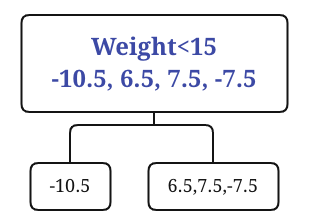

`节点中的值为残差值`

$\color{blue}{\bf{\text{对剪枝的影响：}}}$

现将$\lambda$设定为0的结果和1的结果对比:


If $\lambda = 0:$

- $\text{similarity score}_\text{root_node}= \frac{(-10.5+6.5+7.5-7.5)^2}{1+1+1+1}$ = 4
- $\text{similarity score}_\text{left_node}= \frac{10.5^2}{1+1}$ = 110.25
- $\text{similarity score}_\text{right_node}= \frac{(6.5+7.5-7.5)^2}{1+1+1}$ = 14
- $\text{similarity score gain} = 110.25+14 - 4 = 120.25$

If $\lambda = 1:$

- $\text{similarity score}_\text{root_node}= \frac{(-10.5+6.5+7.5-7.5)^2}{1+1+1+1+1}$ = 3.2
- $\text{similarity score}_\text{left_node}= \frac{10.5^2}{1+1}$ = 55.125
- $\text{similarity score}_\text{right_node}= \frac{(6.5+7.5-7.5)^2}{1+1+1+1}$ = 10.56
- $\text{similarity score gain} = 55.125+10.56-3.2 = 62.485$

所以我们可以总结出：

- $\lambda$越小，则similarity score越大。越大的Similarity Score会更容易超过设定的$\gamma$，则剪枝的可能性越小。
- $\lambda$越大，则similarity score越。越小的Similarity Score会更难超过设定的$\gamma$，则剪枝的可能性越大。

$\color{blue}{\bf{\text{对预测的影响：}}}$

If $\lambda = 0:$

- $\text{output value}_\text{left_node}= \frac{-10.5}{1} = -10.5$
- $\text{output value}_\text{right_node}= \frac{6.5+7.5-7.5}{3} = 2.17$

If $\lambda = 1:$

- $\text{output value}_\text{left_node}= \frac{-10.5}{2} = -5.25$
- $\text{output value}_\text{right_node}= \frac{6.5+7.5-7.5}{4} = 1.625$

所以，$\lambda$可以降低模型预测结果对单个观测的影响程度。例如这里的左节点中只有一个残差值，这时该节点预测的残差值对最终的预测结果影响会很大。

- $\lambda$越大，模型受到单一观测结果的影响程度越小
- $\lambda$越小，模型受到单一观测结果的影响程度越大

**Step 4: Predict Residuals using the Constructed Tree**

最后，构建出最适当的决策树模型后，运用该模型计算出最终每个节点的预测值。该预测值就是我们Step 0中的最优解：

$$O_{value} = \frac{\text{Sum of Residuals}}{\text{Number of Residuals}+\lambda}$$

**Step 5: Update the Prediction Value**

在这一步中，我们用模型预测出的残差值更新最初的预测值。也就是说，将初始的预测值与预测出的残差值相加，让预测值不断靠近真实值。公式如下：

$$\hat{y}^{(t)}_i = \hat{y}^{(t-1)}_i + \eta \times O^{(t-1)}_{value}$$

- $\eta$ 为学习率，默认值为0.3

**Step 6: Repeat from step 1**

然后我们开始从第一步开始重复，创建新的决策树并更新预测值，直到创建决策树学习不再降低残差值。

#### A Case Showing the Intuition of XGBoost

现我们编造一个数据集，通过计算来演示一遍XGBoost的运行逻辑。假设我们有如下数据集：

|Age|Master Degree|Salary|
|---|---|---|
|23|No|50|
|24|Yes|70|
|26|Yes|80|
|27|No|65|
|27|Yes|85|

`Salary`为目标变量

**Step 1: make initial prediction and calculate similarity score**

初始化预测值: $\hat{y} = \frac{\sum_{i=1}^5y_i}{5} = 70$

计算残差值，如下表：

|Age|Master Degree|Salary|Prediction|Residual|
|---|---|---|---|---|
|23|No|50|70|-20|
|24|Yes|70|70|0|
|26|Yes|80|70|10|
|26|No|65|70|-5|
|27|Yes|85|70|15|

计算Similarity Score (我们设定$\lambda$为1):

Similarity Score = $\frac{(-20+0+10-5+15)^2}{6} = 0$

**Step 2: 创建XGBoost Tree 并计算 Similarity Score**

创建XGBoost Tree并迭代特征，计算各自的Similarity Score。

先选用`Master Degree`划分数据，并计算相似度分数和信息增益：

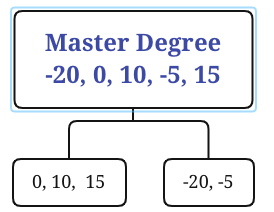

$\lambda$ 默认为1，我们以默认值计算

$$
\text{Similarity Score}_{\text{left node}} = \frac{(0+10+15)^2}{4} = 156.25\\
\text{Similarity Score}_{\text{left node}} = \frac{(-20-5)^2}{3} = 208.33\\
$$

现在为们需要量化用该特征划分数据后叶子内残差的相似度是否有提升，因此我们计算*Similarity Gain*

$$\text{Similarity Gain} = 156.25+208.33-0 = 364.58$$

然后，我们用`Age`划分数据，并计算相似度分数和信息增益。因为Age为连续变量，所以划分数据的过程与离散变量不同。首先计算出`Age`可以取值的所有情况：

- 23+24 = 23.5
- 24+26 = 25
- 26+26 = 26
- 26+27 = 26.5

1. `Age` $\le$ 23.5

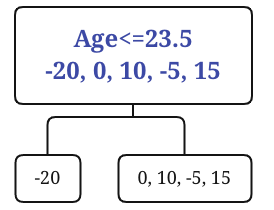

$$
\text{Similarity Score}_{\text{left node}} = \frac{(-20)^2}{2} = 200\\
\text{Similarity Score}_{\text{left node}} = \frac{(0+10-5+15)^2}{5} = 80\\
\text{Similarity Gain} = \frac{(0+10-5-15)^2}{5} = 200+80 - 0 = 280
$$

2. `Age` $\le$ 25

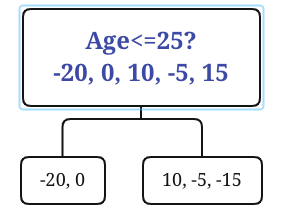

$$
\text{Similarity Score}_{\text{left node}} = \frac{(-20+0)^2}{3} = 133.33\\
\text{Similarity Score}_{\text{left node}} = \frac{(10-5+15)^2}{4} = 100\\
\text{Similarity Gain} = \frac{(0+10-5-15)^2}{5} = 133.33+100- 0 = 233.33
$$

3. `Age` $\le$ 26

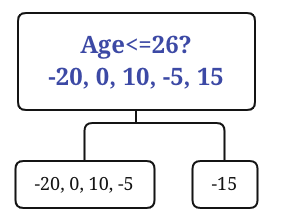

$$
\text{Similarity Score}_{\text{left node}} = \frac{(-20+0+10-5)^2}{5} = 45\\
\text{Similarity Score}_{\text{left node}} = \frac{(-15)^2}{2} = 112.5\\
\text{Similarity Gain} = \frac{(0+10-5-15)^2}{5} = 45+112.5- 0 = 157.5
$$

4. `Age` $\le$ 26.5

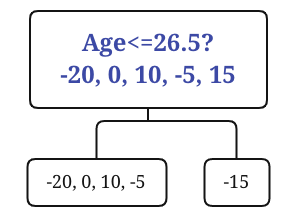

$$
\text{Similarity Score}_{\text{left node}} = \frac{(-20+0+10-5)^2}{5} = 45\\
\text{Similarity Score}_{\text{left node}} = \frac{(-15)^2}{2} = 112.5\\
\text{Similarity Gain} = \frac{(0+10-5-15)^2}{5} = 45+112.5- 0 = 157.5
$$

选取`Age`<=23.5获取的信息增益最大，但是选用年龄获取的增益没有`Master Degree`大，所以第一次划分用`Master Degree`。

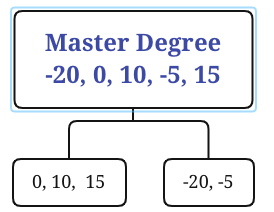

我们继续对左右节点进行划分，因为叶子并不纯，含有多个残差。这里我们仍然尝试`Age`取多个值，并且计算Similarity Gain进行对比。由于逻辑完全一样，计算过程省略。最终结果如下：

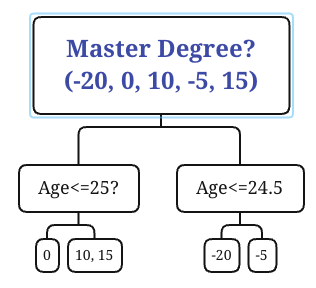



**Step 3: Prune and Regularize the Tree**

我们预先设定增益阀值$\gamma$为50,然后判断决策树的那些分支需要被剪枝。

首先计算`Age`<25该splitting所得出的信息增益：

$$
\text{Similarity Score}_{\text{root node}} = \frac{(0+10+15)^2}{4} = 156.25\\
\text{Similarity Score}_{\text{left node}} = \frac{(0)^2}{2} = 0\\
\text{Similarity Score}_{\text{right node}} = \frac{(10+15)^2}{3} = 208.33\\
\text{Similarity Gain} = \frac{(0+10-5-15)^2}{5} = 208.33-156.25 = 52.08
$$

然后计算`Age`<=24.5分支的信息增益：

$$
\text{Similarity Score}_{\text{root node}} = \frac{(-20-5)^2}{3} = 208.33\\
\text{Similarity Score}_{\text{left node}} = \frac{(-20)^2}{2} = 200\\
\text{Similarity Score}_{\text{right node}} = \frac{(-5)^2}{2} = 12.5\\
\text{Similarity Gain} = \frac{(0+10-5-15)^2}{5} = 200+12.5 - 208.33 = 4.17
$$

由于`Age`<=24.5获取的信息增益小于$\gamma=50$，所以我们要剪掉这个分支，最终模型为：

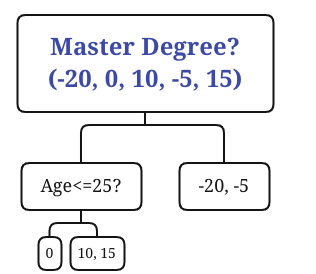

**Step 4: Calculate the Output Value**

$$\because O_{value} = \frac{\text{Sum of Residuals}}{\text{Number of Residuals}+\lambda}\\
\therefore O_{value}^{\text{Age>25|Master Degree}} = \frac{(10+15)}{3} = 8.33\\
\therefore O_{value}^{\text{No Master Degree}} = \frac{(-20-5)}{3} = -8.33 
$$

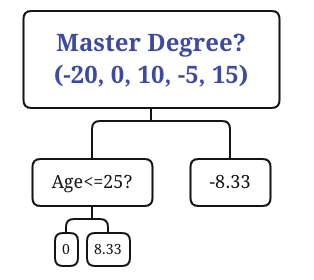

**Step 5: Update the prediction value**

$$\hat{y}^{(t)}_i = \hat{y}^{(t-1)}_i + \eta \times O^{(t-1)}_{value}$$

- $\eta$ 为学习率，默认值为0.3

$$\hat{y}^{(\text{Age>25|Master Degree})} = 70 + 0.3\times -8.33 = 67.501\\
\hat{y}^{(\text{No Master Degree})} = 70 + 0.3\times 8.33 = 72.499
$$

所以，我们更新后的预测值如下：

|Age|Master Degree|Salary|Prediction|
|---|---|---|---|
|23|No|50|67.501|
|24|Yes|70|70|
|26|Yes|80|72.499|
|26|No|65|67.501|
|27|Yes|85|72.499|

然后计算新的残差值：

|Age|Master Degree|Salary|Prediction|Residual|
|---|---|---|---|---|
|23|No|50|67.501|-17.501|
|24|Yes|70|70|0|
|26|Yes|80|72.499|7.501|
|26|No|65|67.501|-2.501|
|27|Yes|85|72.499|12.501|


**Step 6: 从第一步开始重复**

**Reference:**

- [CSIAS](https://www.csias.in/explain-the-step-by-step-implementation-of-xgboost-algorithm/)
- [ML Mastery](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/)
- [IBM](https://www.ibm.com/cloud/learn/boosting)